In [1]:
import os 
import xarray as xr
import numpy as np
import glob
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize
import itertools
from numpy.lib.stride_tricks import sliding_window_view
import datetime
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)


In [38]:
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
data_dir = os.path.join(project_dir, 'data')

# Asbolute vorticity -> level adjustment
var = 'abs_vo'
dataset = 'ERA5dv'
vars_group = 'AV'
basin = 'GLB'
level = 850

# Vertical wind shear -> diff_level adjustment
# var = 'vws'
# dataset = 'ERA5dv'
# vars_group = 'VWS'
# basin = 'GLB'
# level = '850-250'

# Sea surface temperature anomaly -> sea ocean maks adjustment?
var = 'ssta20'
dataset = 'ERA5dv'
vars_group = 'SSTA'
basin = 'GLB'
level = None

# Sea surface temperature -> sea ocean maks adjustment?
var = 'sst'
dataset = 'ERA5'
vars_group = 'MSLP-SST'
basin = 'GLB'
level = None

# Mean sea level pressure -> no adjustment
# var = 'msl'
# dataset = 'ERA5'
# vars_group = 'MSLP-SST'
# basin = 'GLB'
# level = None

n_clusters = 18
norm = False
seasonal_soothing = False
train_yearI, train_yearF = 1980, 2014
test_yearI, test_yearF = 2014, 2021
res = 2.5
resolution = f'{res}x{res}'
if dataset == 'ERA5':
    path_predictor = os.path.join(data_dir, dataset, resolution, vars_group, dataset + '_' + vars_group)
else:
    path_predictor = os.path.join(data_dir, dataset, resolution, vars_group, vars_group)

In [39]:
# Data extraction from .nc files
for y, year in enumerate(range(train_yearI, train_yearF+1)):
    path = path_predictor + f'_{resolution}_{year}.nc'
    if y == 0:
        train_data = xr.open_dataset(path)[var]
    else:
        train_data = xr.concat([train_data, xr.open_dataset(path)[var]], dim='time')
for y, year in enumerate(range(test_yearI, test_yearF+1)):
    path = path_predictor + f'_{resolution}_{year}.nc'
    if y == 0:
        test_data = xr.open_dataset(path)[var]
    else:
        test_data = xr.concat([test_data, xr.open_dataset(path)[var]], dim='time')
if (level != None) and (type(level) == int):
    train_data = train_data.sel(level=level)
    test_data = test_data.sel(level=level)
    var_name = train_data.long_name + ' at ' + str(level) + ' hPa'
elif (level != None) and (type(level) == str):
    train_data = train_data.sel(diff_level=level)
    test_data = test_data.sel(diff_level=level)
    var_name = train_data.long_name + ' between ' + level.split('-')[1] + ' and ' + level.split('-')[0] + ' hPa'
else:
    var_name = train_data.long_name
total_data = xr.concat([train_data, test_data], dim='time')

In [40]:
train_data

<xarray.DataArray 'sst' (time: 420, latitude: 33, longitude: 144)>
array([[[285.08792, 284.77518, 284.3243 , ..., 285.4794 , 285.07407,
         285.73526],
        [287.4035 , 286.89178, 286.25687, ..., 288.08795, 288.03796,
         286.9972 ],
        [288.41702, 288.80652, 288.50314, ..., 289.80173, 290.32037,
         289.21478],
        ...,
        [294.21265, 294.22156, 294.3428 , ..., 292.36325, 293.39658,
         293.95035],
        [293.1828 , 293.03928, 292.77747, ..., 292.048  ,       nan,
         292.79578],
        [291.59073, 291.67288, 291.55957, ..., 289.8819 , 290.38272,
         291.2557 ]],

       [[283.48203, 283.73096, 283.89972, ..., 284.309  , 283.8131 ,
         283.85617],
        [285.6422 , 285.8832 , 285.6833 , ..., 286.55032, 285.90598,
         284.99936],
        [286.59537, 287.02097, 287.1165 , ..., 287.5015 , 288.27203,
         287.47723],
...
        [290.10916, 290.14264, 289.5469 , ..., 289.74683, 290.81235,
         290.465  ],
        [289.34003, 288.7548 , 288.59387, ..., 288.98917,       nan,
         289.37698],
        [287.70877, 287.5968 , 287.33392, ..., 287.54984, 287.4054 ,
         288.0966 ]],

       [[285.0125 , 285.69318, 285.54877, ..., 286.39337, 285.37485,
         286.60828],
        [288.32297, 287.69528, 287.29944, ..., 287.8877 , 288.52588,
         287.96164],
        [291.20865, 291.14517, 290.27808, ..., 289.21158, 291.19516,
         291.24765],
        ...,
        [291.3426 , 291.44406, 291.48502, ..., 291.62097, 292.4636 ,
         292.27615],
        [290.79486, 290.2261 , 289.88727, ..., 291.1482 ,       nan,
         291.20667],
        [290.10117, 289.17358, 288.90222, ..., 289.3515 , 289.23907,
         289.94824]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * latitude   (latitude) float32 40.0 37.5 35.0 32.5 ... -35.0 -37.5 -40.0
  * time       (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2014-12-01
Attributes:
    units:      K
    long_name:  Sea surface temperature

In [31]:
train_data

<xarray.DataArray 'vws' (longitude: 144, latitude: 33, time: 420)>
array([[[16.8754921 , 30.20309448, 32.32630157, ..., 30.14562798,
         37.29992676, 40.0034256 ],
        [24.97095108, 45.87577057, 36.20962524, ..., 25.85494804,
         36.42959976, 41.4348259 ],
        [32.93315125, 57.89773941, 38.65026093, ..., 19.56546211,
         33.38831329, 39.98175049],
        ...,
        [17.34615135, 21.58401489, 27.27951241, ..., 18.75203514,
         19.90924263, 17.73961449],
        [15.58092785, 21.702425  , 23.75065613, ..., 16.04227829,
         17.39860916, 16.90174675],
        [15.84464455, 20.607687  , 20.03770256, ..., 12.36927128,
         15.82834911, 16.08054924]],

       [[16.18654823, 29.10121155, 31.18749237, ..., 29.38566017,
         36.1040802 , 38.30860901],
        [22.81119347, 43.47201157, 34.3958168 , ..., 25.78190041,
         36.36410522, 39.75130081],
        [30.88208199, 55.88851547, 36.20919037, ..., 20.52939034,
         33.55447388, 38.12118912],
...
        [18.92952156, 22.99219704, 28.49036407, ..., 17.83936691,
         18.99611092, 16.68182564],
        [17.64723969, 22.71380043, 23.85534286, ..., 13.7596283 ,
         16.99602509, 16.72904205],
        [15.84244919, 20.67094231, 17.92146873, ..., 11.94458675,
         15.27984715, 14.77826405]],

       [[18.37945366, 31.72395897, 33.5506134 , ..., 30.52466202,
         38.14876938, 41.7326622 ],
        [26.79426193, 48.70569229, 37.13708496, ..., 26.33499908,
         36.61782837, 43.32680893],
        [35.16061401, 59.61508942, 40.37760544, ..., 19.78259277,
         32.72009659, 41.50863266],
        ...,
        [18.04629135, 21.91129684, 27.8671627 , ..., 18.04539871,
         19.60655975, 16.85264206],
        [16.66709328, 22.03565788, 24.40302086, ..., 14.77086449,
         16.89391518, 17.03263092],
        [15.62079334, 19.93667603, 18.2533474 , ..., 11.35294056,
         14.99132729, 14.72795582]]])
Coordinates:
  * longitude   (longitude) float32 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * latitude    (latitude) float32 40.0 37.5 35.0 32.5 ... -35.0 -37.5 -40.0
    diff_level  <U7 '850-250'
  * time        (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2014-12-01
Attributes:
    long_name:      Vertical wind shear
    standard_name:  atmosphere_vertical_wind_shear
    units:          m s**-1

In [24]:
# Reshape the data -> (time, lat, lon) -> (lat*lon, time)
data = train_data.values
data_res = data.reshape(data.shape[0], data.shape[1]*data.shape[2]).T

# Mask the data if there are missing values or if the in a sub-basin
if basin == 'GLB':
    data_res_masked = data_res
else:
    a = 0
    ## NEED TO COMPUTE EVENTUAL MASKING ##
mask = None
# Normalize each time series
if norm==True:
    data_res_masked = normalize(data_res_masked, axis=1, copy=True, return_norm=False)

In [25]:
# Perform clustering
from clustering import cluster_model
cluster = cluster_model(data_res_masked, n_clusters, var)
cluster.check_data()
cluster.kmeans()

Data is a 2D numpy array
Please, be sure the data is in the correct format: (n_samples (nodes), n_features (variables (time))


Index of the closest cluster center for each sample [683, 3931, 8912, 10927, 13037, 7686, 4790, 10161, 2365, 3725, 538, 6709, 12974, 2097, 4238, 5994, 8308, 3335]


ValueError: 'c' argument has 13860 elements, which is inconsistent with 'x' and 'y' with size 4752.

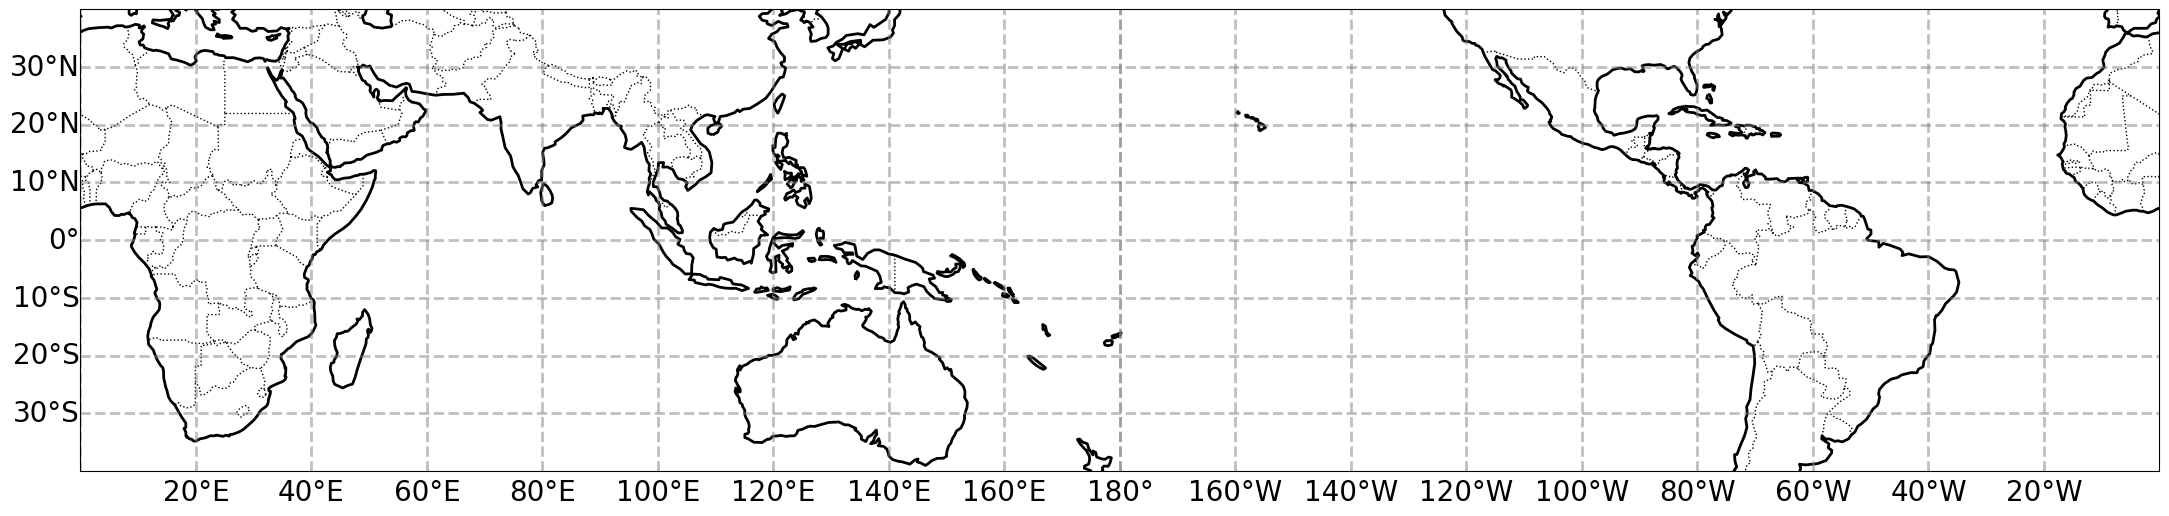

In [26]:
# Get the closest node to the cluster center
centroids = cluster_model.get_closest2center2(cluster, data_res_masked)
# Plot the clusters
latitudes = train_data.latitude.values
longitudes = train_data.longitude.values
# cluster_model.plot_clusters(cluster, data_res_masked, latitudes, longitudes, mask, var_name)

In [30]:
centroids

[683,
 3931,
 8912,
 10927,
 13037,
 7686,
 4790,
 10161,
 2365,
 3725,
 538,
 6709,
 12974,
 2097,
 4238,
 5994,
 8308,
 3335]

In [27]:
# Get the data for the centroids 
iter = itertools.product(latitudes, longitudes)
nodes_list = np.array(list(iter))
lons_c = [np.array(nodes_list)[centroids][i][1] for i in range(len(np.array(nodes_list)[centroids]))]
lats_c = [np.array(nodes_list)[centroids][i][0] for i in range(len(np.array(nodes_list)[centroids]))]

IndexError: index 8912 is out of bounds for axis 0 with size 4752

In [ ]:
# All filtering process of test data is skipped for now
data_filtered_total = total_data

In [ ]:
# Create a dataframe with the centroids time series
centroids_data = []
for i in range(len(centroids)):
    centroid_data = data_filtered_total.sel(latitude=lats_c[i], longitude=lons_c[i]).values
    centroids_data.append(centroid_data)
centroids_dataframe = pd.DataFrame(centroids_data).T
centroids_dataframe.index = data_filtered_total.time.values
centroids_dataframe.columns = [var + basin + '_cluster' + str(i) for i in range(1, n_clusters+1)]

In [ ]:
# Get average data for each cluster, weighted averages are calculated. Batch size is adjusted to avoid memory errors
clusters_av_dataframe = pd.DataFrame(columns=[var + basin + '_cluster' + str(i) for i in range(1, n_clusters+1)])
weights = np.cos(np.deg2rad(nodes_list[:,0]))
data_cluster_avg = data_filtered_total.values

def weighted_average(data, weights):
    weighted_sum = np.dot(weights, data)
    total_weight = np.sum(weights)
    return weighted_sum / total_weight

def calculate_weighted_average(data, weights, batch_size):
    num_rows = data.shape[0]
    result = np.zeros((data.shape[1],))
    
    for i in range(0, num_rows, batch_size):
        if i + batch_size > num_rows:
            batch_data = data[i:]
            batch_weights = weights[i:]
        else:
            batch_data = data[i:i+batch_size]
            batch_weights = weights[i:i+batch_size]
        result += weighted_average(batch_data, batch_weights)
        
    return result / (num_rows/batch_size)

for c in range(len(centroids)):
    cluster_mask = cluster.labels == c
    batch_size = 100
    data_cluster_avg_masked = data_cluster_avg.reshape(data_cluster_avg.shape[0], data_cluster_avg.shape[1]*data_cluster_avg.shape[2]).T[cluster_mask]
    weights_masked = weights[cluster_mask]
    cluster_avg = calculate_weighted_average(data_cluster_avg_masked, weights_masked, batch_size)
    clusters_av_dataframe[var + basin + '_cluster' + str(c+1)] = cluster_avg

clusters_av_dataframe.index = data_filtered_total.time.values

In [ ]:
# Create a dataframe with the cluster labels
labels_dataframe = pd.DataFrame(cluster.labels, columns=['cluster'])
labels_dataframe['nodes_lat'] = np.array(nodes_list)[:,0]
labels_dataframe['nodes_lon'] = np.array(nodes_list)[:,1]
labels_dataframe['cluster'] = labels_dataframe['cluster'] + 1